In [1]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
mongo = MongoClient(port=27017)

In [2]:
# Load data from Excel
file_path = '/Users/janelu/Desktop/project/Core_CPI_not seas_adj.xlsx'
monthly_data = pd.read_excel(file_path, sheet_name='monthly')

# Remove entirely empty rows and create a clean copy
monthly_data_cleaned = monthly_data.dropna(how='all').copy()

# Rename the 'Date' column
monthly_data_cleaned.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

# Convert 'Date' column to datetime format
monthly_data_cleaned['Date'] = pd.to_datetime(
    monthly_data_cleaned['Date'].str.replace('M', '-').astype(str),
    format='%Y-%m'
)


In [3]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["cpi_database"]
collection = db["cpi_data"]

# Prepare data for insertion
records = []
for _, row in monthly_data_cleaned.iterrows():
    for country in ["Brazil", "Canada", "United States"]:  # Specify countries of interest
        if pd.notna(row[country]):
            records.append({
                "date": row["Date"],
                "country": country,
                "cpi": row[country]
            })

# Insert data into MongoDB
collection.insert_many(records)


InsertManyResult([ObjectId('6757eafade6b0494180878e7'), ObjectId('6757eafade6b0494180878e8'), ObjectId('6757eafade6b0494180878e9'), ObjectId('6757eafade6b0494180878ea'), ObjectId('6757eafade6b0494180878eb'), ObjectId('6757eafade6b0494180878ec'), ObjectId('6757eafade6b0494180878ed'), ObjectId('6757eafade6b0494180878ee'), ObjectId('6757eafade6b0494180878ef'), ObjectId('6757eafade6b0494180878f0'), ObjectId('6757eafade6b0494180878f1'), ObjectId('6757eafade6b0494180878f2'), ObjectId('6757eafade6b0494180878f3'), ObjectId('6757eafade6b0494180878f4'), ObjectId('6757eafade6b0494180878f5'), ObjectId('6757eafade6b0494180878f6'), ObjectId('6757eafade6b0494180878f7'), ObjectId('6757eafade6b0494180878f8'), ObjectId('6757eafade6b0494180878f9'), ObjectId('6757eafade6b0494180878fa'), ObjectId('6757eafade6b0494180878fb'), ObjectId('6757eafade6b0494180878fc'), ObjectId('6757eafade6b0494180878fd'), ObjectId('6757eafade6b0494180878fe'), ObjectId('6757eafade6b0494180878ff'), ObjectId('6757eafade6b0494180879

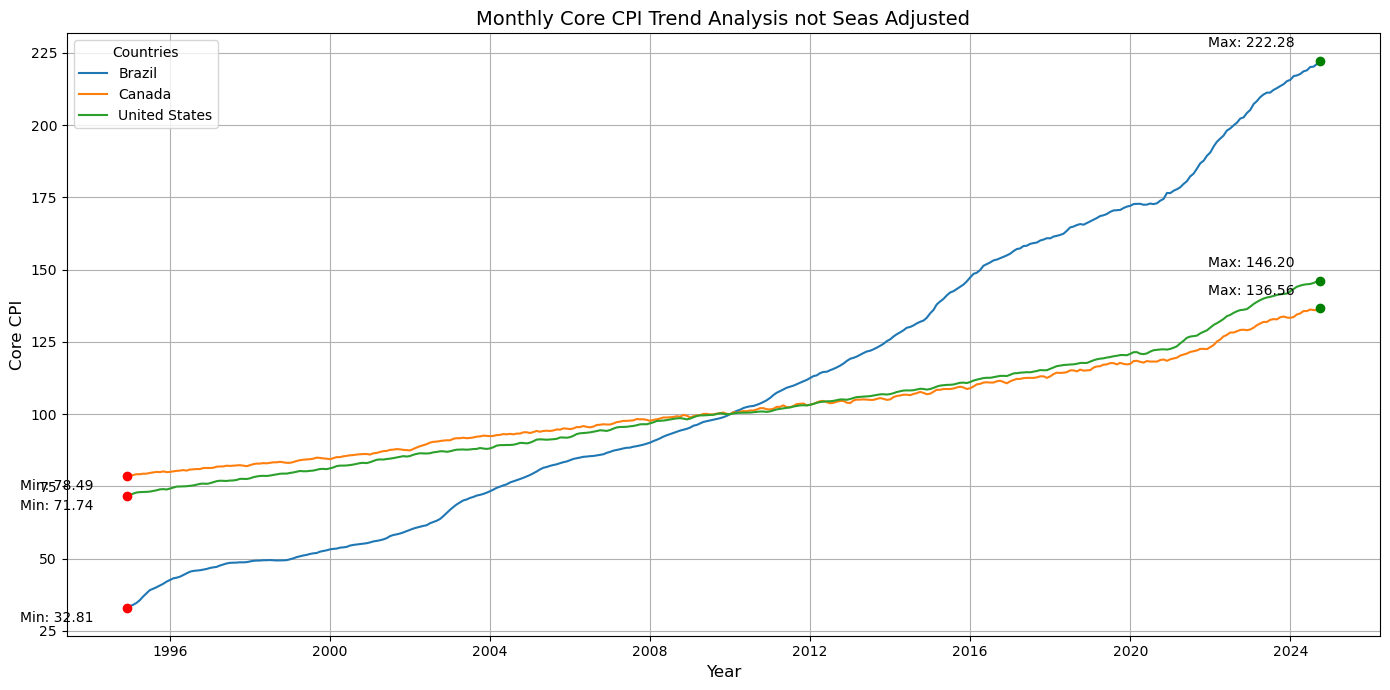

In [8]:
# Exclude the '_id' field when querying from MongoDB
query_results = collection.find({"country": {"$in": ["Brazil", "Canada", "United States"]}}, {"_id": 0})

# Load query results into a Pandas DataFrame
trend_data = pd.DataFrame(list(query_results))

# Ensure 'date' is in datetime format
trend_data["date"] = pd.to_datetime(trend_data["date"])

# Remove duplicates by keeping the first occurrence
trend_data = trend_data.drop_duplicates(subset=["date", "country"])

# OR: Aggregate duplicates by averaging (if duplicates are valid)
trend_data = trend_data.groupby(["date", "country"], as_index=False).mean()

# Pivot data for easier visualization
trend_data_pivot = trend_data.pivot(index="date", columns="country", values="cpi")

# Plot the trends
plt.figure(figsize=(14, 7))
for country in trend_data_pivot.columns:
    country_data = trend_data_pivot[country]
    
    # Plot the trend line
    plt.plot(trend_data_pivot.index, country_data, label=country)
    
    # Find the lowest and highest points
    min_point_date = country_data.idxmin()
    min_point_value = country_data.min()
    max_point_date = country_data.idxmax()
    max_point_value = country_data.max()
    
    # Highlight the lowest point
    plt.scatter(min_point_date, min_point_value, color='red', zorder=5)
    plt.annotate(f"Min: {min_point_value:.2f}", 
                 (min_point_date, min_point_value),
                 textcoords="offset points", xytext=(-50, -10), ha='center')
    
    # Highlight the highest point
    plt.scatter(max_point_date, max_point_value, color='green', zorder=5)
    plt.annotate(f"Max: {max_point_value:.2f}", 
                 (max_point_date, max_point_value),
                 textcoords="offset points", xytext=(-50, 10), ha='center')

# Customize the plot
plt.title("Monthly Core CPI Trend Analysis not Seas Adjusted", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Core CPI", fontsize=12)
plt.legend(title="Countries", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


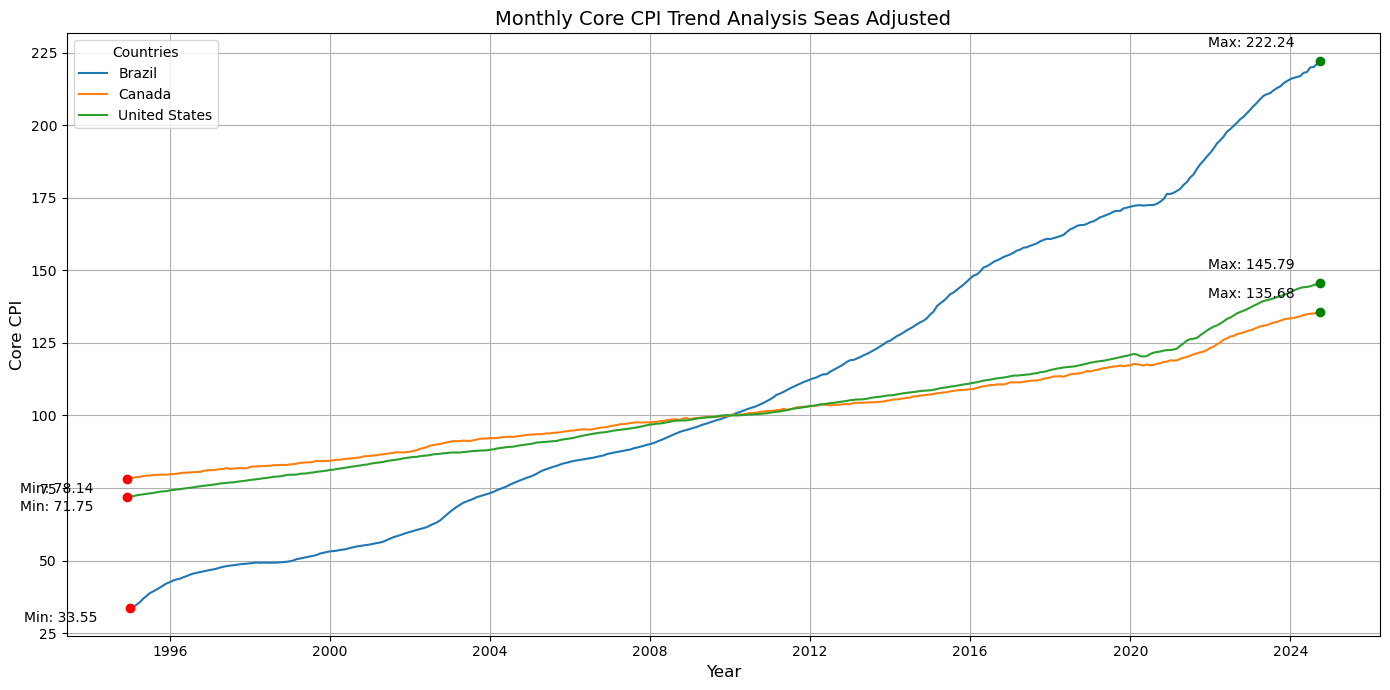

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Use the uploaded file path
file_path = '/Users/janelu/Desktop/project/Core_CPI_seas_adj.xlsx'

# Load the Excel file
monthly_data = pd.read_excel(file_path, sheet_name='monthly')

# Remove entirely empty rows and create a clean copy
monthly_data_cleaned = monthly_data.dropna(how='all').copy()

# Rename the 'Date' column
monthly_data_cleaned.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

# Convert 'Date' column to datetime format
monthly_data_cleaned['Date'] = pd.to_datetime(
    monthly_data_cleaned['Date'].str.replace('M', '-').astype(str),
    format='%Y-%m'
)

# Filter data for specific countries of interest
countries_of_interest = ["Brazil", "Canada", "United States"]
filtered_data = monthly_data_cleaned[["Date"] + countries_of_interest].dropna(how='all')

# Reshape the data for easier plotting
trend_data = filtered_data.melt(id_vars="Date", 
                                value_vars=countries_of_interest, 
                                var_name="Country", 
                                value_name="CPI")

# Plot the trends
plt.figure(figsize=(14, 7))
for country in countries_of_interest:
    country_data = trend_data[trend_data["Country"] == country]
    
    # Plot the trend line
    plt.plot(country_data["Date"], country_data["CPI"], label=country)
    
    # Find the lowest and highest points
    min_point = country_data.loc[country_data["CPI"].idxmin()]
    max_point = country_data.loc[country_data["CPI"].idxmax()]
    
    # Highlight the lowest point
    plt.scatter(min_point["Date"], min_point["CPI"], color='red', zorder=5)
    plt.annotate(f"Min: {min_point['CPI']:.2f}", 
                 (min_point["Date"], min_point["CPI"]),
                 textcoords="offset points", xytext=(-50, -10), ha='center')
    
    # Highlight the highest point
    plt.scatter(max_point["Date"], max_point["CPI"], color='green', zorder=5)
    plt.annotate(f"Max: {max_point['CPI']:.2f}", 
                 (max_point["Date"], max_point["CPI"]),
                 textcoords="offset points", xytext=(-50, 10), ha='center')

# Customize the plot
plt.title("Monthly Core CPI Trend Analysis Seas Adjusted", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Core CPI", fontsize=12)
plt.legend(title="Countries", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()
